In [1]:
import pandas as pd
import numpy as np
import warnings 
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from gensim.corpora import Dictionary

In [2]:
import sys
print(sys.version)

3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]


In [3]:
import pyLDAvis
import pyLDAvis.gensim_models

In [4]:
from bs4 import BeautifulSoup

def remove_html_tags_code(text):
    soup = BeautifulSoup(text, 'html.parser')
    code_tags = soup.find_all('code')
    for code_tag in code_tags:
        code_tag.decompose()
    return soup.get_text()

In [5]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in text]
    return lemmatized_text

In [6]:
def remove_stop_short_words(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words and len(word) > 2]
    return filtered_text

In [7]:
def filter_tokens(tokens, dictionary):
    return [token for token in tokens if token in dictionary.token2id]

In [37]:
def removed_word_frequency(nb_words, dictionary_before, dictionary_after):

# Get the words removed after filtering
    words_removed = set(dictionary_before.token2id.keys()) - set(dictionary_after.token2id.keys())

# Get the document frequencies of the removed words
    removed_word_dfs = [dictionary_before.dfs[dictionary_before.token2id[word]] for word in words_removed]

# Sort the removed words by their document frequency in descending order
    sorted_removed_words = sorted(zip(words_removed, removed_word_dfs), key=lambda x: x[1], reverse=False)
# Select the top nb_words removed words
    least_documents_words = sorted_removed_words[:nb_words]

# Extract the words and document frequencies for plotting
    words = [word for word, _ in least_documents_words]
    dfs = [df for _, df in least_documents_words]

# Create a bar chart of the top removed words
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(words)), dfs)
    plt.yticks(range(len(words)), words)
    plt.xlabel('Document Frequency')
    plt.ylabel('Words')
    plt.title('Top Least Frequent Words Removed')
    plt.show()

# Sort the removed words by their document frequency in descending order
    sorted_removed_words = sorted(zip(words_removed, removed_word_dfs), key=lambda x: x[1], reverse=True)
# Select the top nb_words removed words
    most_documents_words = sorted_removed_words[:nb_words]

# Extract the words and document frequencies for plotting
    words = [word for word, _ in most_documents_words]
    dfs = [df for _, df in most_documents_words]

# Create a bar chart of the top removed words
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(words)), dfs)
    plt.yticks(range(len(words)), words)
    plt.xlabel('Document Frequency')
    plt.ylabel('Words')
    plt.title('Top Most Frequent Words Removed')
    plt.show()
    
    reduction_ratio = len(dictionary_after) / len(dictionary_before)
    reduction_ratio = round(1-reduction_ratio, 2)  # Round the ratio to two decimal places
    print("nb mots avant = ",len(dictionary_before), "  nombre de mots après = ", len(dictionary_after), "ratio de réduction = ", reduction_ratio )
    return reduction_ratio

# Retrieve data  

SQL Query : 
SELECT TOP 50000 Title, Body, Tags, Id, Score, ViewCount, FavoriteCount, AnswerCount
FROM Posts
WHERE PostTypeId = 1 AND Score >= 0 AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5

In [9]:
warnings.filterwarnings('ignore')

In [10]:
data =  pd.read_csv('QueryResults.csv',  engine = 'python',  on_bad_lines = 'skip', index_col=[0])

In [11]:
col = data.columns
col

Index(['Body', 'Tags', 'Id', 'Score', 'ViewCount', 'FavoriteCount',
       'AnswerCount'],
      dtype='object')

In [12]:
data.reset_index(inplace=True)

In [13]:
data.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,Access Denied when using Power Shell Remoting ...,<p>I want to remotely trigger some commands wi...,<windows><powershell><server><core><remoting>,54569222,2,2151,NaN,2
1,Preprocess SHPAML in Django's template loader?,<p>Is there any way to make Django's template ...,<python><django><templates><preprocessor><shpaml>,2131029,3,585,0.0,2
2,Writing eclipse templates,<p>I am writing django templates in Eclipse->p...,<django><eclipse><templates><eclipse-plugin><e...,2131039,7,554,0.0,1
3,Auto update and build with eclipse and SVN,<p>every morning when i come to work i update ...,<eclipse><svn><build-process><performance><sub...,2131045,2,1262,NaN,1
4,Use .NET in VB6 or classical ASP,"<p><strong>Duplicate of</strong> <a href=""http...",<.net><com><vb6><asp-classic><wrapper>,2131111,3,1548,0.0,3


# 1. Traitement des donnees

## 1.1 Analyse des données 

### 1.1.1  Réduction des variables  

In [14]:
scores = ["Score","ViewCount","AnswerCount","FavoriteCount"]
data[scores].describe()

,Score,ViewCount,AnswerCount,FavoriteCount
count,50000.000000,5.000000e+04,50000.000000,16615.0
mean,7.165040,7.016561e+03,1.842580,0.0
std,96.430085,6.698717e+04,2.377358,0.0
min,0.000000,1.300000e+01,0.000000,0.0
25%,0.000000,2.710000e+02,1.000000,0.0
50%,1.000000,8.540000e+02,1.000000,0.0
75%,3.000000,2.515000e+03,2.000000,0.0
max,9350.000000,7.766370e+06,111.000000,0.0


FavoriteCount est vide, à éliminer

In [15]:
data = data.drop('FavoriteCount', axis=1)

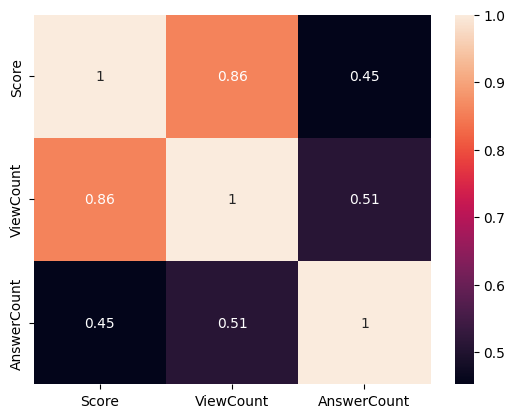

In [16]:
sns.heatmap(data[["Score","ViewCount","AnswerCount"]].corr(), annot=True)
plt.show()

il y a une corrélation forte entre score et viewcount, supprimer viewcount

In [17]:
data = data.drop('ViewCount', axis=1)

### 1.1.2  Vérification valeurs invalides

verifie la valeur nulle ou négative

In [18]:
data[["Score","AnswerCount"]].isnull().sum().sum()

0

In [19]:
(data[["Score", "AnswerCount"]] < 0).sum().sum()

0

il y a une corrélation forte entre score et viewcount, supprimer viewcount

### 1.1.3  Chargement des données

In [20]:
corpus = data[['Id', 'Title', 'Body', 'Tags', 'Score', 'AnswerCount']].copy()

## 1.2 Traitements de title

In [21]:
corpus.dtypes

Id              int64
Title          object
Body           object
Tags           object
Score           int64
AnswerCount     int64
dtype: object

In [22]:
# Normalisation de la casse (mise en minuscules)
corpus['Title_process'] = corpus['Title'].str.lower()
corpus[['Title', 'Title_process']].head()

,Title,Title_process
0,Access Denied when using Power Shell Remoting ...,access denied when using power shell remoting ...
1,Preprocess SHPAML in Django's template loader?,preprocess shpaml in django's template loader?
2,Writing eclipse templates,writing eclipse templates
3,Auto update and build with eclipse and SVN,auto update and build with eclipse and svn
4,Use .NET in VB6 or classical ASP,use .net in vb6 or classical asp


In [23]:
# Supprimer les caractères spéciaux  
# les caractères qui ne sont pas des lettres de l'alphabet (majuscules ou minuscules) y compris des chiffres sauf '-'
corpus['Title_process'] = corpus['Title_process'].apply(lambda x: re.sub('[^a-zA-Z_]', ' ', str(x)))
corpus[['Title', 'Title_process']].head()

,Title,Title_process
0,Access Denied when using Power Shell Remoting ...,access denied when using power shell remoting ...
1,Preprocess SHPAML in Django's template loader?,preprocess shpaml in django s template loader
2,Writing eclipse templates,writing eclipse templates
3,Auto update and build with eclipse and SVN,auto update and build with eclipse and svn
4,Use .NET in VB6 or classical ASP,use net in vb or classical asp


In [24]:
# Tokenization (découpage en mots)
corpus['Title_process'] = corpus['Title_process'].apply(nltk.word_tokenize)
corpus[['Title', 'Title_process']].head(10)

,Title,Title_process
0,Access Denied when using Power Shell Remoting ...,"[access, denied, when, using, power, shell, re..."
1,Preprocess SHPAML in Django's template loader?,"[preprocess, shpaml, in, django, s, template, ..."
2,Writing eclipse templates,"[writing, eclipse, templates]"
3,Auto update and build with eclipse and SVN,"[auto, update, and, build, with, eclipse, and,..."
4,Use .NET in VB6 or classical ASP,"[use, net, in, vb, or, classical, asp]"
5,Having trouble getting Algolia Search to recog...,"[having, trouble, getting, algolia, search, to..."
6,Java client for REST web service with Netbeans,"[java, client, for, rest, web, service, with, ..."
7,Aurelia starting with params passed by PHP,"[aurelia, starting, with, params, passed, by, ..."
8,Mamp connect to a global sql database,"[mamp, connect, to, a, global, sql, database]"
9,Mahapp Metro Window Title not visible in TaskBar,"[mahapp, metro, window, title, not, visible, i..."


In [25]:
# Supprimer les mots non informatifs (stop words)
corpus['Title_process'] = corpus['Title_process'].apply(lambda x: remove_stop_short_words(x))
corpus[['Title', 'Title_process']].head(5)

,Title,Title_process
0,Access Denied when using Power Shell Remoting ...,"[access, denied, using, power, shell, remoting..."
1,Preprocess SHPAML in Django's template loader?,"[preprocess, shpaml, django, template, loader]"
2,Writing eclipse templates,"[writing, eclipse, templates]"
3,Auto update and build with eclipse and SVN,"[auto, update, build, eclipse, svn]"
4,Use .NET in VB6 or classical ASP,"[use, net, classical, asp]"


In [26]:
# Lemmatisation
# We use the WordNet lemmatizer from NLTK. A lemmatizer is preferred over a stemmer 
# in this case because we want contextual keyword and lemmatizer takes this into account, while stemmer doesn't.
corpus['Title_process'] = corpus['Title_process'].apply(lambda x: lemmatize_text(x))
corpus[['Title', 'Title_process']].head()

,Title,Title_process
0,Access Denied when using Power Shell Remoting ...,"[access, denied, using, power, shell, remoting..."
1,Preprocess SHPAML in Django's template loader?,"[preprocess, shpaml, django, template, loader]"
2,Writing eclipse templates,"[writing, eclipse, template]"
3,Auto update and build with eclipse and SVN,"[auto, update, build, eclipse, svn]"
4,Use .NET in VB6 or classical ASP,"[use, net, classical, asp]"


In [27]:
# Réduction de tokens extrèmes,  les 100 tokens les plus fréquents et les tokens présents 
# dans moins de 5 documents sont supprimés

# Create the dictionary before filtering
dictionary_before = corpora.Dictionary(corpus['Title_process'])

# Create an empty dictionary
dictionary_after = corpora.Dictionary(corpus['Title_process'])

# Filter extremes
dictionary_after.filter_extremes(no_below=3)
dictionary_after.filter_n_most_frequent(8)

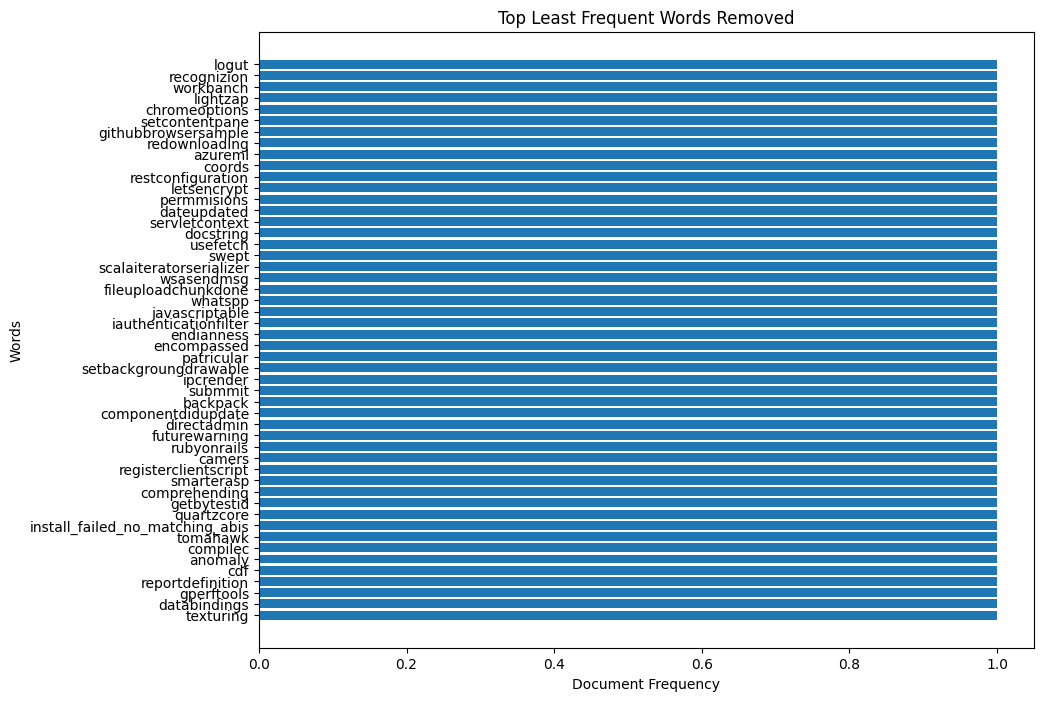

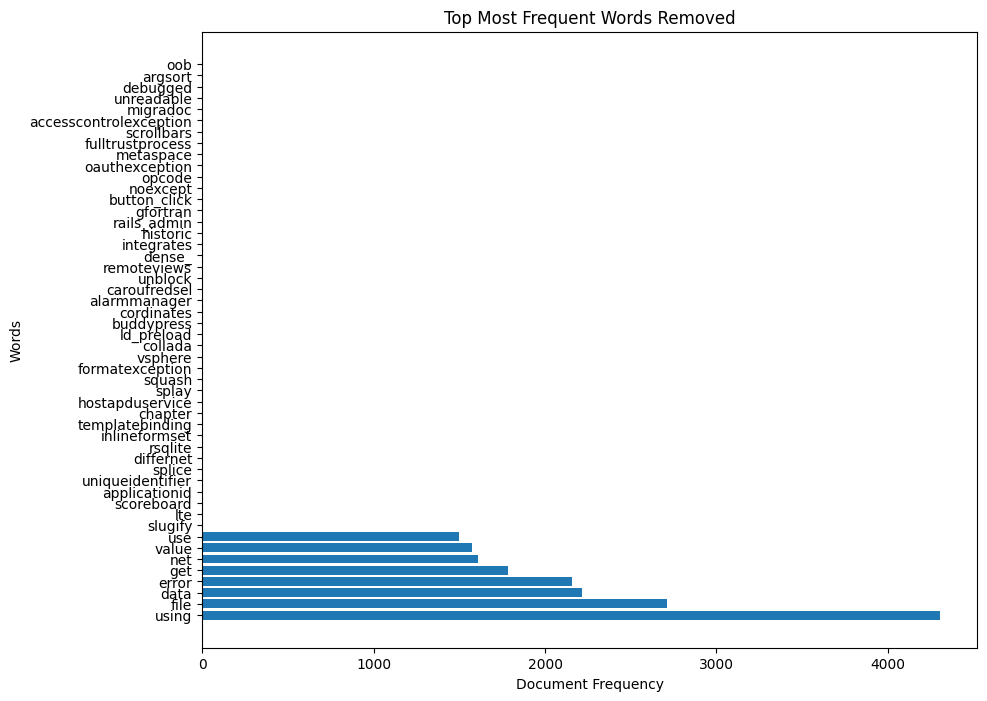

nb mots avant =  21746   nombre de mots après =  7075 ratio de réduction =  0.67


In [38]:
ratio = removed_word_frequency(50, dictionary_before, dictionary_after)

In [34]:
print("reduction ratio is ", ratio)

reduction ratio is  0.67


In [29]:
# Mise à jour de traitement de title avec le résultat de filtrage
corpus['Title_tokens'] = corpus['Title_process'].apply(lambda x: filter_tokens(x, dictionary_after))

In [30]:
corpus[['Title', 'Title_process','Title_tokens' ]].to_csv('title1.csv', index=False)

In [31]:
corpus.head()

,Id,Title,Body,Tags,Score,AnswerCount,Title_process,Title_tokens
0,54569222,Access Denied when using Power Shell Remoting ...,<p>I want to remotely trigger some commands wi...,<windows><powershell><server><core><remoting>,2,2,"[access, denied, using, power, shell, remoting...","[access, denied, power, shell, remoting, local..."
1,2131029,Preprocess SHPAML in Django's template loader?,<p>Is there any way to make Django's template ...,<python><django><templates><preprocessor><shpaml>,3,2,"[preprocess, shpaml, django, template, loader]","[django, template, loader]"
2,2131039,Writing eclipse templates,<p>I am writing django templates in Eclipse->p...,<django><eclipse><templates><eclipse-plugin><e...,7,1,"[writing, eclipse, template]","[writing, eclipse, template]"
3,2131045,Auto update and build with eclipse and SVN,<p>every morning when i come to work i update ...,<eclipse><svn><build-process><performance><sub...,2,1,"[auto, update, build, eclipse, svn]","[auto, update, build, eclipse, svn]"
4,2131111,Use .NET in VB6 or classical ASP,"<p><strong>Duplicate of</strong> <a href=""http...",<.net><com><vb6><asp-classic><wrapper>,3,3,"[use, net, classical, asp]",[asp]


## 1.3 traitement de body

In [39]:
# Normalisation de la casse (mise en minuscules)
corpus['Body_process'] = corpus['Body'].str.lower()

In [40]:
# Enleve les tags html et les codes
corpus['Body_process'] = corpus['Body_process'].astype(str).apply(remove_html_tags_code)

In [41]:
# Supprimer les caractères spéciaux  
# les caractères qui ne sont pas des lettres de l'alphabet (majuscules ou minuscules) y compris des chiffres sauf '-'
corpus['Body_process'] = corpus['Body_process'].apply(lambda x: re.sub('[^a-zA-Z_]', ' ', str(x)))

In [42]:
# Tokenization (découpage en mots)
corpus['Body_process'] = corpus['Body_process'].apply(nltk.word_tokenize)

In [43]:
# Supprimer les mots non informatifs (stop words)
corpus['Body_process'] = corpus['Body_process'].apply(lambda x: remove_stop_short_words(x))

In [44]:
# Lemmatisation
corpus['Body_process'] = corpus['Body_process'].apply(lambda x: lemmatize_text(x))

In [45]:
corpus[['Body', 'Body_process']].head(10)

,Body,Body_process
0,<p>I want to remotely trigger some commands wi...,"[want, remotely, trigger, command, power, shel..."
1,<p>Is there any way to make Django's template ...,"[way, make, django, template, loader, run, tem..."
2,<p>I am writing django templates in Eclipse->p...,"[writing, django, template, eclipse, prefrence..."
3,<p>every morning when i come to work i update ...,"[every, morning, come, work, update, source, s..."
4,"<p><strong>Duplicate of</strong> <a href=""http...","[duplicate, calling, net, method, via, com, vi..."
5,<p>I've recently implemented the Algolia Searc...,"[recently, implemented, algolia, search, wordp..."
6,<p>I am trying to write a Java client for a RE...,"[trying, write, java, client, rest, web, servi..."
7,<p>I need to pas params to Aurelia on start. D...,"[need, pa, params, aurelia, start, depending, ..."
8,<p>Im using mamp to create a local server and ...,"[using, mamp, create, local, server, run, pho,..."
9,<p>I am using MahApp MetroWindow which has a t...,"[using, mahapp, metrowindow, title, template, ..."


In [46]:
# Réduction de tokens extrèmes,  les 50 tokens les plus fréquents et les tokens présents 
# dans moins de 3 documents sont supprimés

# Create the dictionary before filtering
dictionary_before = corpora.Dictionary(corpus['Body_process'])

# Create an empty dictionary
dictionary_after = corpora.Dictionary(corpus['Body_process'])

# Filter extremes
dictionary_after.filter_extremes(no_below=3)
dictionary_after.filter_n_most_frequent(33)

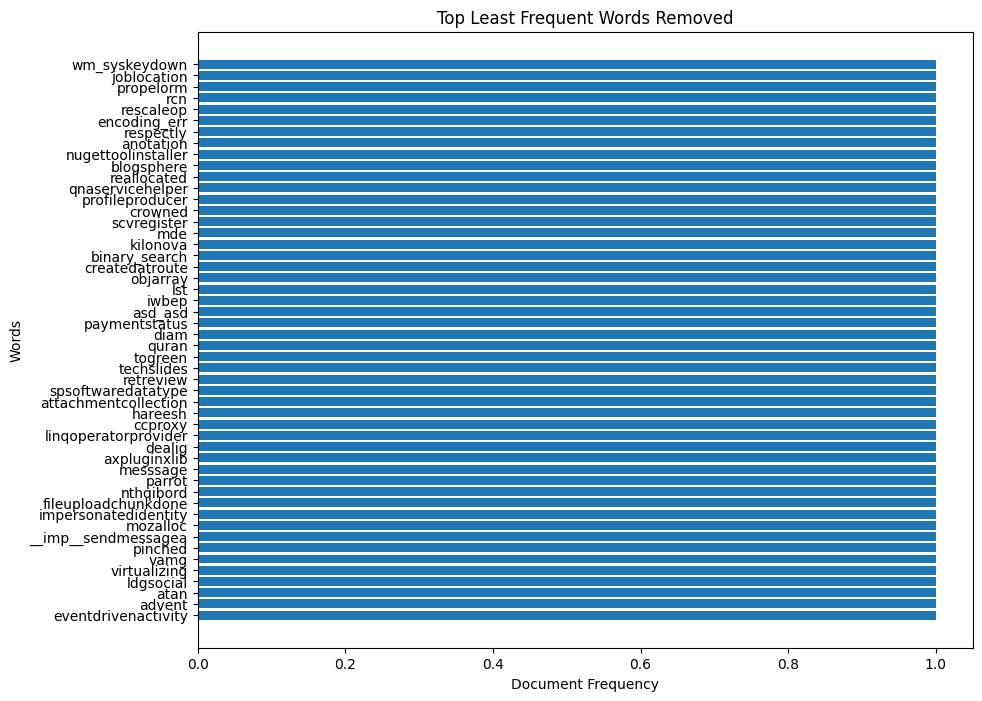

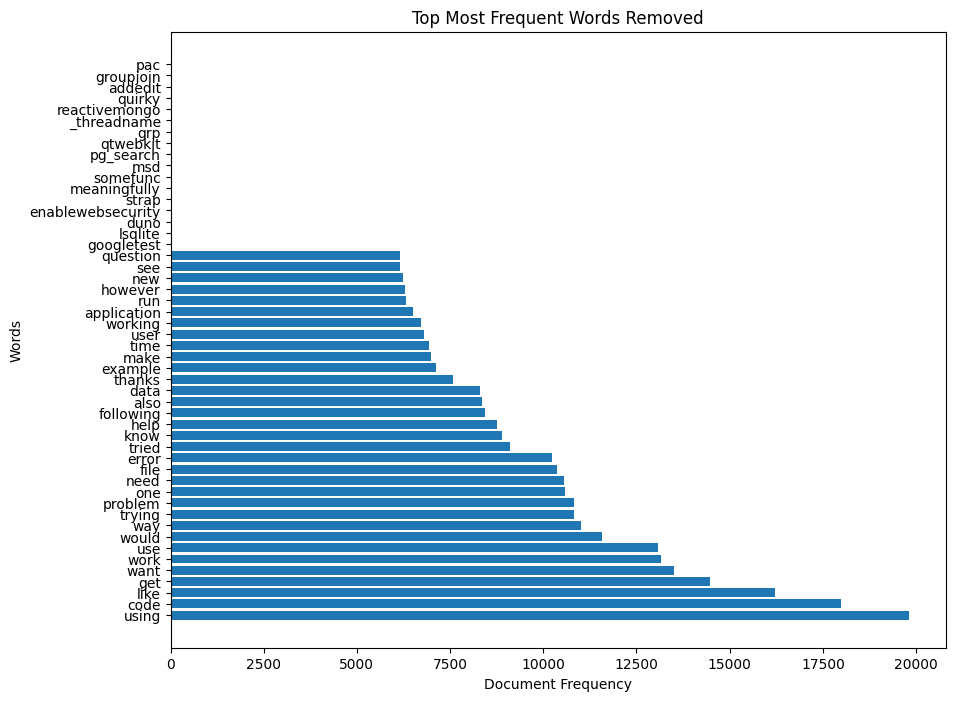

nb mots avant =  78903   nombre de mots après =  17518 ratio de réduction =  0.78


In [47]:
ratio_body = removed_word_frequency(50, dictionary_before, dictionary_after)

In [48]:
print("reduction ratio is ", ratio_body)

reduction ratio is  0.78


In [49]:
# Mise à jour de traitement de title avec le résultat de filtrage
corpus['Body_tokens'] = corpus['Body_process'].apply(lambda x: filter_tokens(x, dictionary_after))

In [50]:
corpus['Body_tokens'].head()

0    [remotely, trigger, command, power, shell, win...
1    [django, template, loader, template, load, dir...
2    [writing, django, template, eclipse, template,...
3    [every, morning, come, update, source, svn, bu...
4    [duplicate, calling, net, method, via, com, vi...
Name: Body_tokens, dtype: object

In [51]:
corpus[['Title', 'Title_tokens', 'Body', 'Body_tokens']].to_csv('title_body1.csv', index=False)

In [52]:
corpus.columns

Index(['Id', 'Title', 'Body', 'Tags', 'Score', 'AnswerCount', 'Title_process',
       'Title_tokens', 'Body_process', 'Body_tokens'],
      dtype='object')

## 1.4 traitement de tag

Les tag sont traité pour extraire les tokens, ensuite les tokens les moins utilisés sont filtrés

In [53]:
def processTags(tags) : 
    # use regex to extract tags to list 
    regex = '<([^>]+)>'
    tagslist = re.split(regex, tags)
    # filter None values 
    tagslist_clean = filter(None, tagslist)
    # all tags to lower case 
    tagslist_lower = [ str(x).lower() for x in tagslist_clean ] 
    return tagslist_lower

In [54]:
corpus["Tag_token"] = corpus["Tags"].apply(processTags)

In [55]:
tag_count = corpus["Tag_token"].explode().value_counts()

In [56]:
len(tag_count) # number of unique tags 

18713

In [57]:
print(tag_count[:20])

Tag_token
javascript     6953
c#             6093
java           5979
python         4239
php            3566
html           3532
jquery         3469
android        3136
ios            2715
c++            2547
.net           2403
css            2158
asp.net        1820
sql            1736
mysql          1457
node.js        1360
objective-c    1282
arrays         1279
json           1240
ajax           1216
Name: count, dtype: int64


supprimer les tag qui apparaisse moins de trois fois 

In [58]:
filtered_tags = tag_count[tag_count >= 3].index.tolist()
corpus["Tag_token"] = corpus["Tag_token"].apply(lambda tags: [tag for tag in tags if tag in filtered_tags])

In [59]:
tag_count = corpus["Tag_token"].explode().value_counts()
len(tag_count) # number of unique tags 

7740

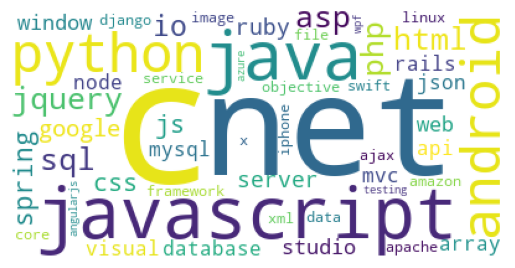

In [60]:
# Convert values to strings before joining
text = ' '.join(map(str, corpus["Tag_token"].explode()))

# Create the wordcloud object
wordcloud = WordCloud(collocations=False, background_color='white', max_words=50).generate(text)

# Display the word cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [61]:
corpus.columns

Index(['Id', 'Title', 'Body', 'Tags', 'Score', 'AnswerCount', 'Title_process',
       'Title_tokens', 'Body_process', 'Body_tokens', 'Tag_token'],
      dtype='object')

In [62]:
corpus[['Id', 'Title', 'Title_tokens', 'Body', 'Body_tokens', 'Tags', 'Tag_token', \
        'Score', 'AnswerCount']].to_csv('data_processed.csv', index=False)

In [63]:
corpus[['Id', 'Title', 'Title_tokens', 'Body', 'Body_tokens', 'Tags', 'Tag_token', \
        'Score', 'AnswerCount']].to_parquet('data_processed.parquet')

# 2 Extraction des features 

In [64]:
# 3 options : 
#  - fit title, transform title en bow
#  - fit title, transform title + body en bow
#  - fit title + body, transform title + body  en bow

X = corpus[['Title_tokens', 'Body_tokens']]
y = corpus['Tags']

# Split the Title_tokens into train and test sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

X_train_title = X_train['Title_tokens']
X_test_title = X_test['Title_tokens']
X_train_body = X_train['Body_tokens']
X_test_body = X_test['Body_tokens']
print(X_train_title[:10])

39087                                  [stored, procedure]
30893                         [run, fly, tomcat, netbeans]
45278    [show, gray, color, view, io, navigation, bar,...
16398    [form, authentication, ticket, decryption, pos...
13653                                    [validation, yii]
13748    [count, number, self, referential, relationshi...
23965       [python, keyerror, even, column, name, exists]
45552    [regex, number, possible, digit, dot, comma, t...
30219                      [removing, dot, string, python]
24079                   [datagridview, display, datatable]
Name: Title_tokens, dtype: object


## 2.1  Bag of word

In [65]:
# Convert the list of tokenized words to a list of strings
X_train_title = [' '.join(tokens) for tokens in X_train_title]
X_train_body = [' '.join(tokens) for tokens in X_train_body]
X_test_title = [' '.join(tokens) for tokens in X_test_title]
X_test_body = [' '.join(tokens) for tokens in X_test_body]

In [66]:
print(X_train_title[:10])

['stored procedure', 'run fly tomcat netbeans', 'show gray color view io navigation bar uisplitviewcontroller', 'form authentication ticket decryption possible php', 'validation yii', 'count number self referential relationship fit certain criterion combined query sqlalchemy', 'python keyerror even column name exists', 'regex number possible digit dot comma text', 'removing dot string python', 'datagridview display datatable']


Option 1: Fit vectorizer on X_train_title and transform X_train_title into bag-of-words representation.

In [67]:
# Fit vectorizer on X_train_title
vectorizer_title = CountVectorizer()
vectorizer_title.fit(X_train_title)

# Transform X_train_title into bag-of-words representation
bow_train_title = vectorizer_title.transform(X_train_title)
bow_test_title = vectorizer_title.transform(X_test_title)

In [71]:
feature_names = vectorizer_title.get_feature_names()
num_features = len(feature_names)
print("Number of features:", num_features)

# Print the vocabulary (unique words)
print("Vocabulary:")
print(vectorizer_title.get_feature_names()[:20])

# Print the bag-of-words representation of the training data
print("Bag-of-Words (Train):")
print(bow_train_title.toarray()[:2])

Number of features: 7061
Vocabulary:
['__init__', '__m', '_general_ci', '_get', '_post', '_session', 'aac', 'aar', 'abbreviation', 'abi', 'abide', 'ability', 'able', 'abnormal', 'abort', 'aborted', 'abruptly', 'absolute', 'absolutely', 'abstract']
Bag-of-Words (Train):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Option 2: Fit vectorizer on X_train_title, and transform X_train_title + X_train_body into bag-of-words representation.

In [69]:
# Transform X_train_title + body into bag-of-words representation
bow_train_title_body = vectorizer_title.transform(X_train_title + X_train_body)
bow_test_title_body = vectorizer_title.transform(X_test_title + X_test_body)

In [72]:
feature_names = vectorizer_title.get_feature_names()
num_features = len(feature_names)
print("Number of features:", num_features)

# Print the vocabulary (unique words)
print("Vocabulary:")
print(vectorizer_title.get_feature_names()[:20])

# Print the bag-of-words representation of the training data
print("Bag-of-Words (Train):")
print(bow_train_title.toarray()[:2])

# Print the bag-of-words representation of the test data
print("Bag-of-Words (Test):")
print(bow_test_title.toarray()[:2])

Number of features: 7061
Vocabulary:
['__init__', '__m', '_general_ci', '_get', '_post', '_session', 'aac', 'aar', 'abbreviation', 'abi', 'abide', 'ability', 'able', 'abnormal', 'abort', 'aborted', 'abruptly', 'absolute', 'absolutely', 'abstract']
Bag-of-Words (Train):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Bag-of-Words (Test):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Option 3: Fit vectorizer on X_train_title + X_train_body, and transform X_train_title + X_train_body into bag-of-words representation.

In [73]:
# Fit vectorizer on X_train_title + body
vectorizer_title_body = CountVectorizer()
vectorizer_title_body.fit(X_train_title + X_train_body)

# Transform X_train_title + body into bag-of-words representation
bow_train = vectorizer_title_body.transform(X_train_title + X_train_body)
bow_test = vectorizer_title_body.transform(X_test_title + X_test_body)

In [74]:
# Print the vocabulary (unique words)
feature_names = vectorizer_title_body.get_feature_names()
num_features = len(feature_names)
print("Number of features:", num_features)

print("Vocabulary:")
print(vectorizer_title_body.get_feature_names()[:20])

# Print the bag-of-words representation of the training data
print("Bag-of-Words (Train):")
print(bow_train_title.toarray()[:2])

# Print the bag-of-words representation of the test data
print("Bag-of-Words (Test):")
print(bow_test_title.toarray()[:2])

Number of features: 17662
Vocabulary:
['___', '____', '__cdecl', '__construct', '__declspec', '__dopostback', '__error', '__get', '__gnu_cxx', '__init__', '__m', '__nsarraym', '__thiscall', '__tostring', '_create', '_encode', '_files', '_form', '_general_ci', '_get']
Bag-of-Words (Train):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Bag-of-Words (Test):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## 2.2 TF-IDF

Option 1: Fit vectorizer on X_train_title and transform X_train_title into Tfidf representation.

In [75]:
# Fit vectorizer on X_train_title
vectorizer_title_tfidf = TfidfVectorizer()
vectorizer_title_tfidf.fit(X_train_title)

# Transform X_train_title into bag-of-words representation
tfidf_train_title = vectorizer_title_tfidf.transform(X_train_title)

In [76]:
# Get the TF-IDF features of the first document
first_document_features = tfidf_train_title[0]

print(first_document_features)

  (0, 5906)	0.6961359305669073
  (0, 4657)	0.7179099986584294


In [80]:
feature_names = vectorizer_title.get_feature_names_out()
num_features = len(feature_names)
print("Number of features:", num_features)

# Get the TF-IDF features of the first document
first_document_features = tfidf_train_title[1]

print(first_document_features)

Number of features: 7061
  (0, 6305)	0.46311041973807804
  (0, 5292)	0.369459689713063
  (0, 3896)	0.5245557161559359
  (0, 2214)	0.611448752926426


Option 2: Fit vectorizer on X_train_title, and transform X_train_title + X_train_body into Tfidf representation.

In [81]:
# Transform X_train_title + body into bag-of-words representation
tfidf_train_title_body = vectorizer_title_tfidf.transform(X_train_title + X_train_body)

In [394]:
# Get the TF-IDF features of the first document
first_document_features = tfidf_train_title_body[0]

print(first_document_features)

  (0, 2797)	0.5830485139878834
  (0, 2226)	0.6012853805060279
  (0, 1889)	0.39982651225193594
  (0, 966)	0.37235612204809354


In [83]:
feature_names = vectorizer_title.get_feature_names_out()
num_features = len(feature_names)
print("Number of features:", num_features)

# Get the TF-IDF features of the first document
first_document_features = tfidf_train_title_body[2]

print(first_document_features)

Number of features: 7061
  (0, 6720)	0.2562057006110907
  (0, 6493)	0.51408761368772
  (0, 5574)	0.2769972873572543
  (0, 3870)	0.3209107944633901
  (0, 2985)	0.2470112655961706
  (0, 2475)	0.4890725690015198
  (0, 1009)	0.3065081322544273
  (0, 508)	0.31017342084965704


Option 3: Fit vectorizer on X_train_title + X_train_body, and transform X_train_title + X_train_body into bag-of-words representation.

In [88]:
# Fit vectorizer on X_train_title + body
vectorizer_title_body_tfidf = CountVectorizer()
vectorizer_title_body_tfidf.fit(X_train_title + X_train_body)

# Transform X_train_title + body into bag-of-words representation
tfidf_train = vectorizer_title_body_tfidf.transform(X_train_body)

In [395]:
# Get the TF-IDF features of the first document
first_document_features = tfidf_train[0]

print(first_document_features)

  (0, 2571)	1
  (0, 4893)	1
  (0, 5731)	1
  (0, 7176)	1


In [89]:
feature_names = vectorizer_title_body_tfidf.get_feature_names_out()
num_features = len(feature_names)
print("Number of features:", num_features)

# Get the TF-IDF features of the first document
first_document_features = tfidf_train[2]

print(first_document_features)

Number of features: 17662
  (0, 253)	1
  (0, 721)	2
  (0, 746)	1
  (0, 765)	2
  (0, 766)	1
  (0, 1341)	1
  (0, 2678)	1
  (0, 3039)	1
  (0, 3099)	6
  (0, 4019)	2
  (0, 4046)	1
  (0, 4370)	1
  (0, 4389)	1
  (0, 4577)	1
  (0, 4693)	1
  (0, 5281)	2
  (0, 5443)	1
  (0, 5825)	1
  (0, 6198)	1
  (0, 6998)	1
  (0, 7004)	1
  (0, 7119)	1
  (0, 7758)	1
  (0, 7763)	1
  (0, 7824)	1
  (0, 7841)	1
  (0, 7915)	2
  (0, 8490)	1
  (0, 8628)	1
  (0, 9149)	2
  (0, 9598)	2
  (0, 10006)	1
  (0, 10037)	1
  (0, 10259)	1
  (0, 11395)	1
  (0, 11493)	1
  (0, 11976)	1
  (0, 13402)	1
  (0, 13816)	2
  (0, 14475)	3
  (0, 14787)	2
  (0, 15481)	1
  (0, 16177)	1
  (0, 16595)	1
  (0, 16825)	9
  (0, 17428)	1
